### Figures of spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [3]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder = '/data/brogalla/run_storage/ave-tracer-fields/'

# Boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(113/N, 1, N)
vals_glac[:, 1] = np.linspace(169/N, 1, N)
vals_glac[:, 2] = np.linspace(144/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [4]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [8]:
# Load Mn results
file_ref   = 'ANHA12_EXH006_ref_seasonal_field.nc'
file_glac  = 'ANHA12_EXH006_riv-2a_seasonal_field.nc'
file_cont  = 'ANHA12_EXH006_riv-2b_seasonal_field.nc'

base_monthly = nc.Dataset(folder+file_ref); 
glac_monthly = nc.Dataset(folder+file_glac); 
cont_monthly = nc.Dataset(folder+file_cont);

dmn_base = np.array(base_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_glac = np.array(glac_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_cont = np.array(cont_monthly.variables['dissolmn'])[0,:,0,:,:]

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [9]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

##### Calculations:

In [10]:
glacier_prop = calculate_prop(dmn_base, dmn_glac)
cont_prop    = calculate_prop(dmn_base, dmn_cont)

##### Figures

In [11]:
# Average over the top meters
glac_prop = np.nanmean(glacier_prop[:,0:10,:,:], axis=1)
cont_prop = np.nanmean(cont_prop[:,0:10,:,:], axis=1)

# Mask small values:
ma_glac = np.ma.masked_where((glac_prop < 0.008), glac_prop)
ma_cont = np.ma.masked_where((cont_prop < 0.008), cont_prop)
ma_both = ma_cont + ma_glac

In [12]:
reference_month = 0
# refc = np.nanmean(cont_prop[reference_month,:,:], axis=0)
# refg = np.nanmean(glac_prop[reference_month,:,:], axis=0)
refc = np.nanmean(cont_prop[:,:,:], axis=0)
refg = np.nanmean(glac_prop[:,:,:], axis=0)

diff_glac    = np.array([(glac_prop[month,:,:]-refg)*100 for month in range(0,12)])
diff_glacier = np.ma.masked_where((diff_glac < 0.3) & (diff_glac > -0.3), diff_glac)

diff_cont        = np.array([(cont_prop[month,:,:]-refc)*100 for month in range(0,12)])
diff_continental = np.ma.masked_where((diff_cont < 0.3) & (diff_cont > -0.3), diff_cont)

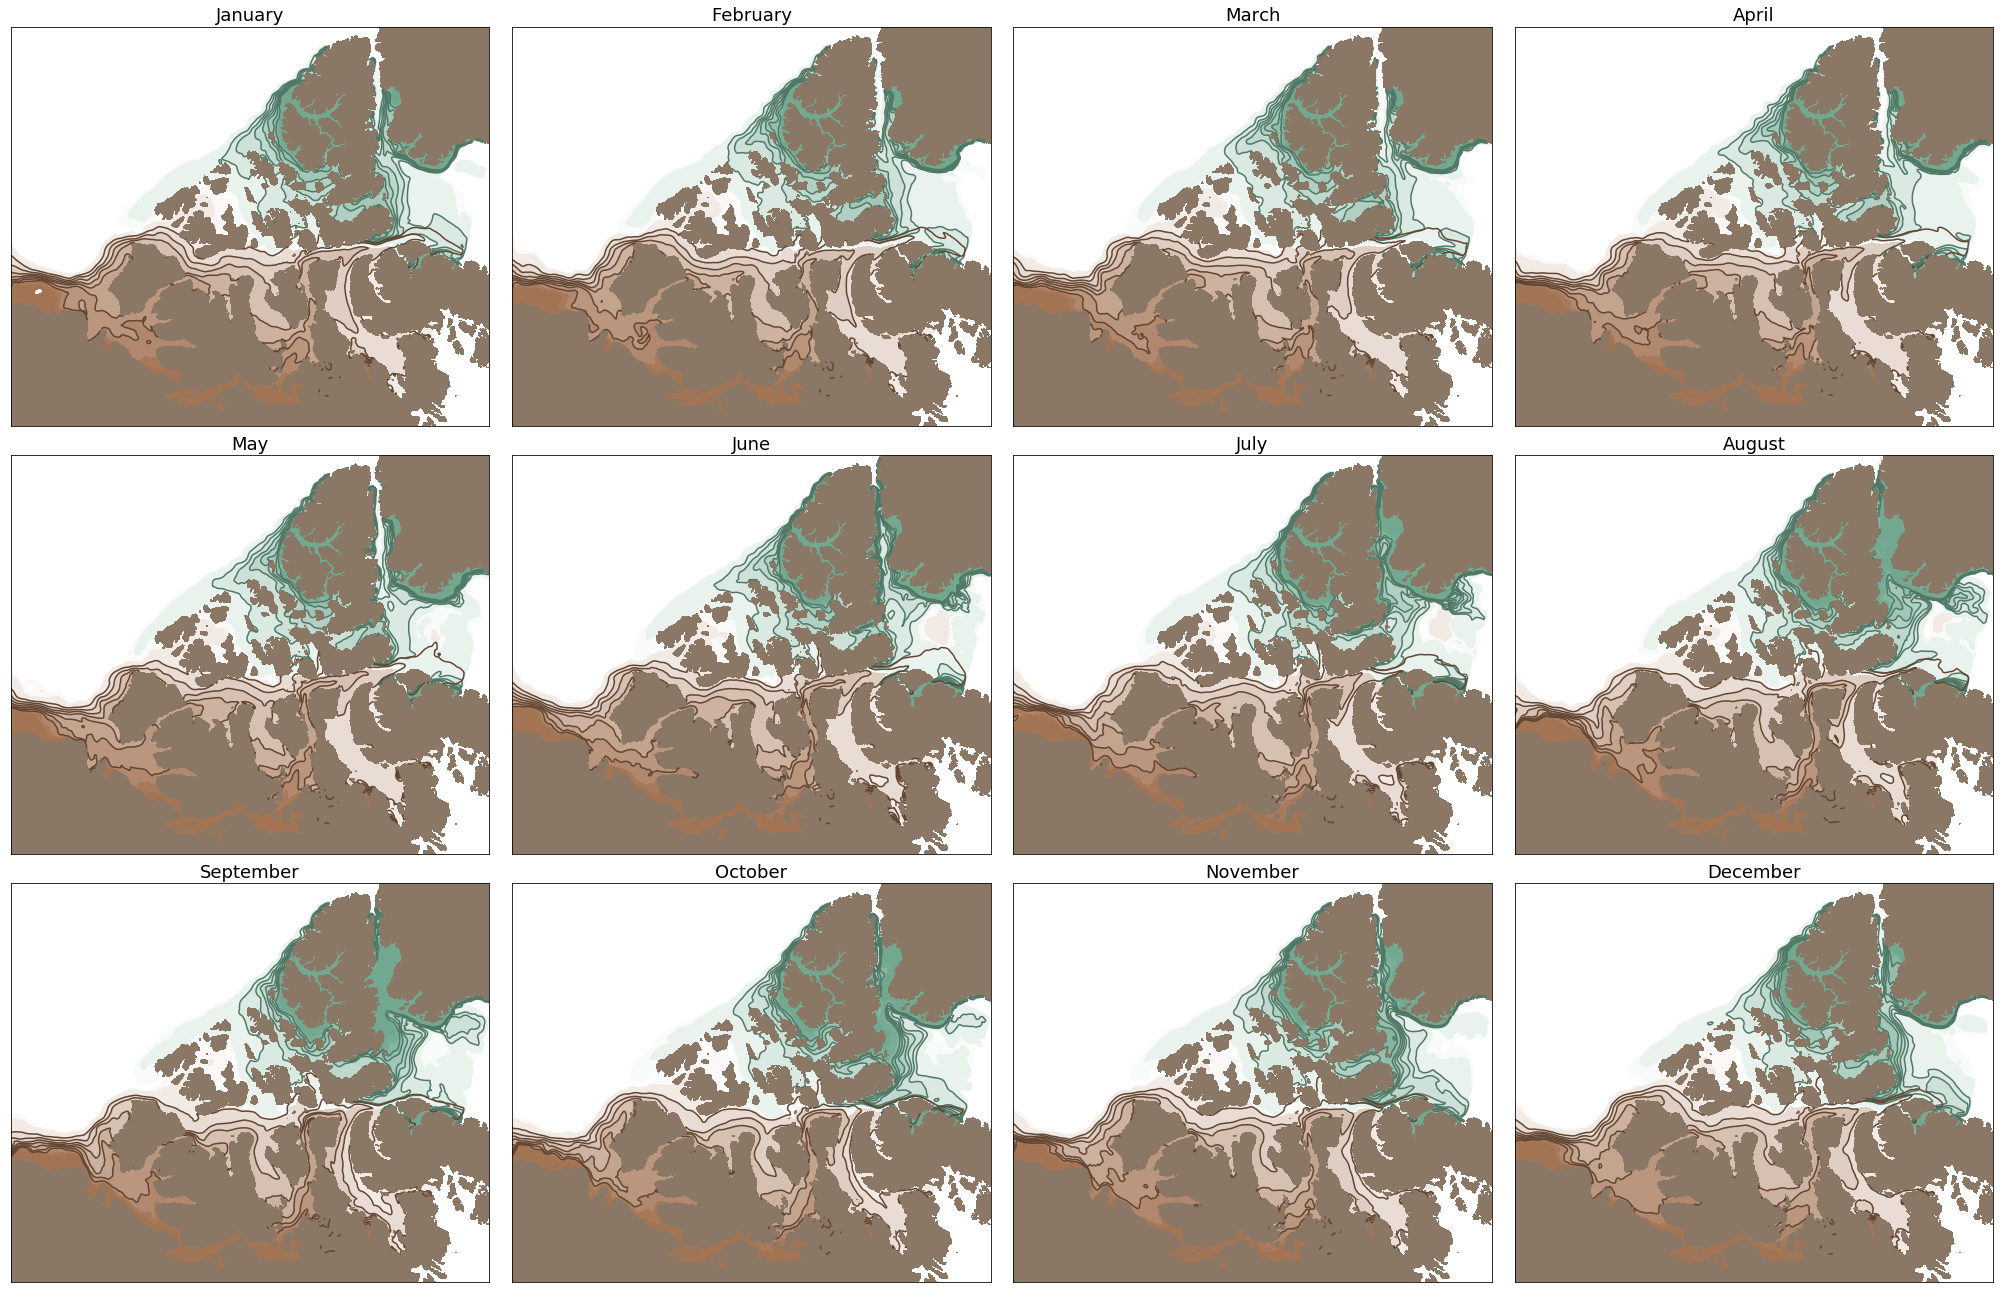

In [11]:
fig, ax = plt.subplots(3,4, figsize=(28,18))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month < 8) & (month > 3):
        ax1 = ax[1,month-4]
    else:
        ax1 = ax[2,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -105, resolution='i', width=2.4e6, height=2.0e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    # Coloured contours:
    vmin_cont = 0; vmax_cont = 10; step_cont = 1;
    vmin_glac = 0; vmax_glac = 10; step_glac = 1;
    CS2 = proj2.contourf(x_model, y_model, ma_cont[month,:,:]*100, \
                         levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                         vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
    CS1 = proj2.contourf(x_model, y_model, ma_glac[month,:,:]*100, \
                         levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                         vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')

    # Contour lines:
    vmin_cglac=2; vmin_ccont = 2;
    contour_glac = 1; cvmax_glac = 8;
    contour_cont = 1; cvmax_cont = 8;
    glac = proj2.contour(x_model, y_model, ma_glac[month,:,:]*100, \
                         levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                         vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')
    cont = proj2.contour(x_model, y_model, ma_cont[month,:,:]*100, \
                         levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                         vmin=vmin_ccont, vmax=vmax_cont, colors='#624532')

#     ax1.clabel(glac, [2], inline=1, fontsize=10, fmt='%1.f')
#     ax1.clabel(cont, [2, 4, 8], inline=1, fontsize=10, fmt='%1.f')
    
    ax1.set_title(months[month], fontsize=18)

    
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1
    
    
# # Colorbars:
# cbaxes1 = fig.add_axes([0.91, 0.23, 0.04, 0.34]) 
# cbaxes2 = fig.add_axes([0.99, 0.23, 0.04, 0.34])  
# CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes2, ticks=np.arange(0,16,2), drawedges=True) 
# CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes1, ticks=np.arange(0,16,2), drawedges=True) 
# CBar1.ax.tick_params(axis='y', length=0, labelsize=14)
# CBar2.ax.tick_params(axis='y', length=0, labelsize=14)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

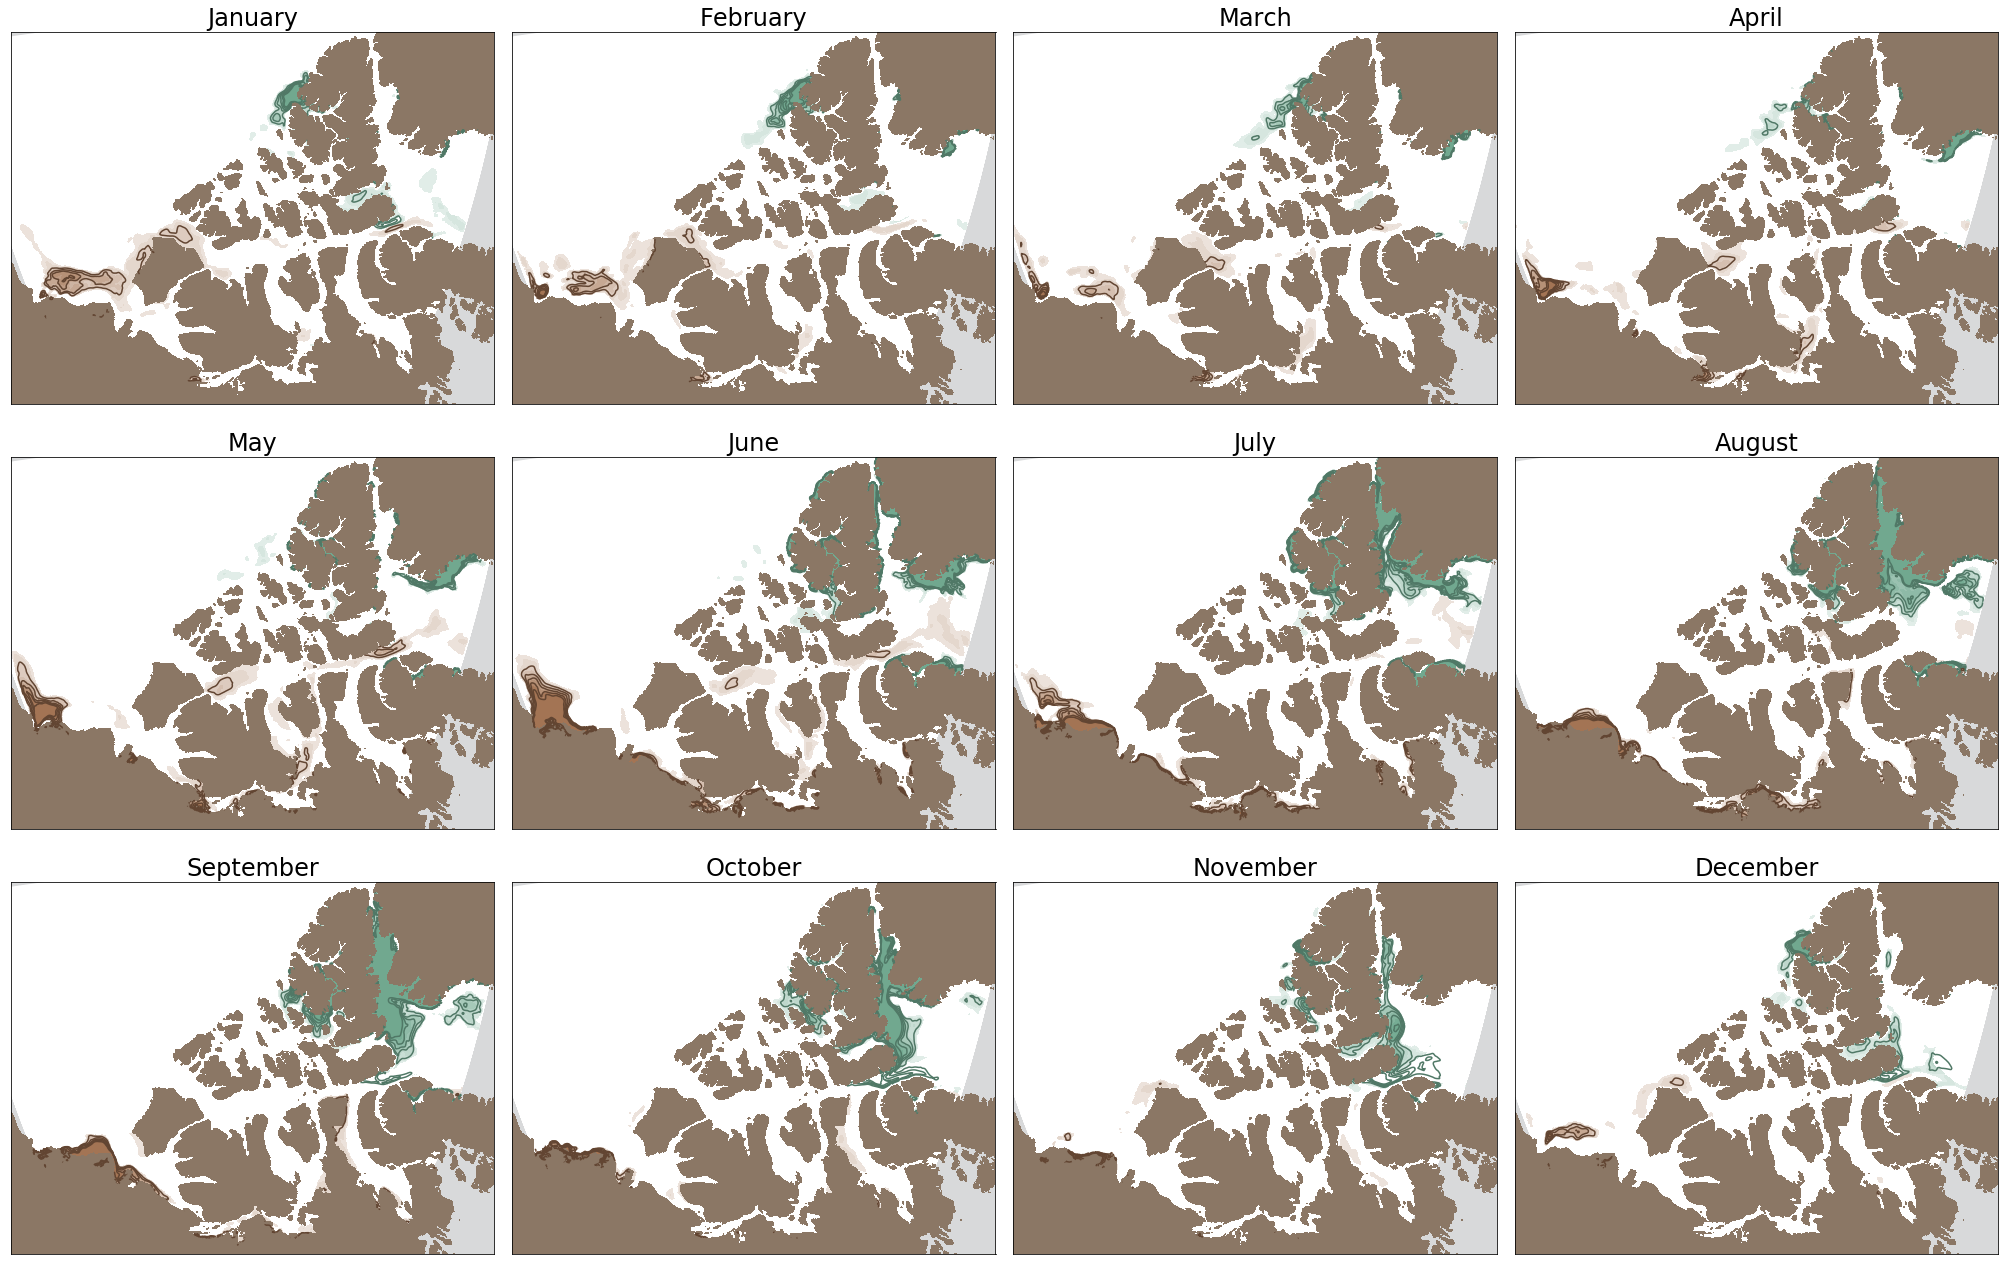

In [12]:
fig, ax = plt.subplots(3,4, figsize=(28,18))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month < 8) & (month > 3):
        ax1 = ax[1,month-4]
    else:
        ax1 = ax[2,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -107, resolution='i', width=2.6e6, height=2.0e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    vmin_glac = 0; vmax_glac = 3; step_glac = .25;
    vmin_cont = 0; vmax_cont = 3; step_cont = .25;

    CS1 = proj2.contourf(x_model, y_model, diff_glacier[month], \
                         levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                         vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')
    CS2 = proj2.contourf(x_model, y_model, diff_continental[month], \
                         levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                         vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
    
    # Contour lines:
    vmin_cglac=0; vmin_ccont = 0;
    contour_glac = .5; cvmax_glac = 3;
    contour_cont = .5; cvmax_cont = 3;
    glac = proj2.contour(x_model, y_model, diff_glacier[month,:,:], \
                         levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                         vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')
    cont = proj2.contour(x_model, y_model, diff_continental[month,:,:], \
                         levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                         vmin=vmin_ccont, vmax=vmax_cont, colors='#624532')

    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

    
# fig.suptitle('Monthly addition of riverine Mn')
    
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

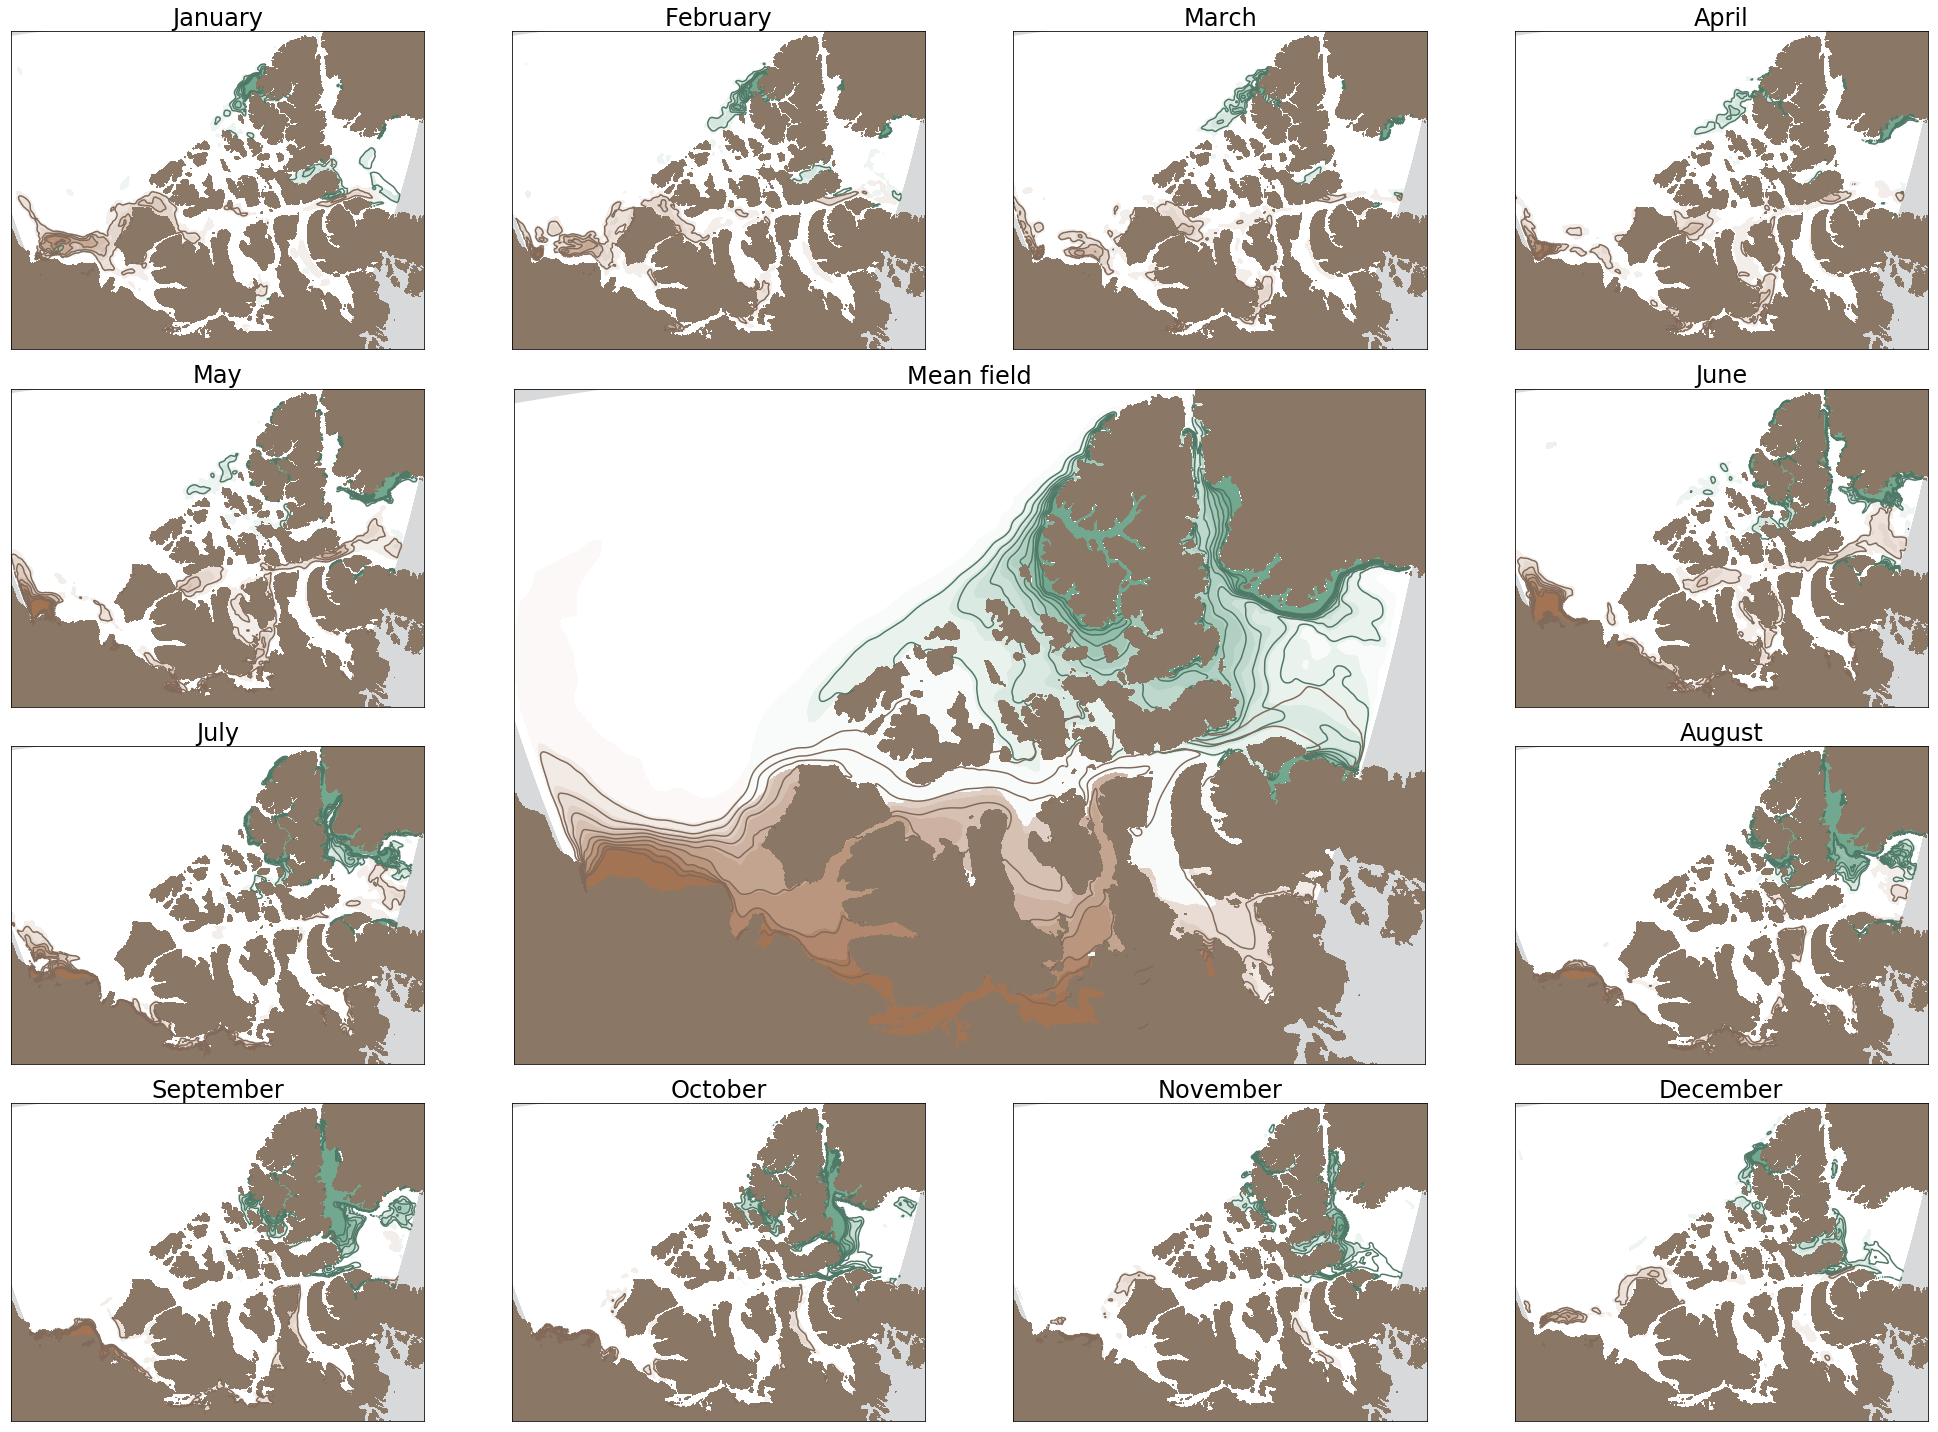

In [13]:
fig, ax = plt.subplots(4,4, figsize=(28,20))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month == 4):
        ax1 = ax[1,0]
    elif (month == 5):
        ax1 = ax[1,3]
    elif (month == 6):
        ax1 = ax[2,0]
    elif (month == 7):
        ax1 = ax[2,3]
    else:
        ax1 = ax[3,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -107, resolution='i', width=2.6e6, height=2.0e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    vmin_glac = 0; vmax_glac = 3; step_glac = .25;
    vmin_cont = 0; vmax_cont = 3; step_cont = .25;

    CS1 = proj2.contourf(x_model, y_model, diff_glacier[month], \
                         levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                         vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')
    CS2 = proj2.contourf(x_model, y_model, diff_continental[month], \
                         levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                         vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
    
    # Contour lines:
    vmin_cglac = 0; contour_glac = .5; cvmax_glac = 3;
    vmin_ccont = 0; contour_cont = .5; cvmax_cont = 3;
    glac = proj2.contour(x_model, y_model, diff_glacier[month,:,:], \
                         levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                         vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')
    cont = proj2.contour(x_model, y_model, diff_continental[month,:,:], \
                         levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                         vmin=vmin_ccont, vmax=vmax_cont, colors='#816a5a')

    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

    
    
ax2 = plt.subplot2grid((4, 4), (1, 1), colspan=2, rowspan=2)
proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -108, resolution='i', width=2.7e6, height=2.0e6, ax=ax2)
x_land, y_land = proj2(lon, lat)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

x_model, y_model = proj2(lons, lats)

vmin_glac = 0; vmax_glac = 10; step_glac = 1;
vmin_cont = 0; vmax_cont = 10; step_cont = 1;

refc_masked = np.ma.masked_where((refc*100 < 0.25), refc*100)
refg_masked = np.ma.masked_where((refg*100 < 0.25), refg*100)

CS2 = proj2.contourf(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                     vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
CS1 = proj2.contourf(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                     vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')


vmin_cglac = 0; contour_glac = 1.15; cvmax_glac = 10;
vmin_ccont = 0; contour_cont = 1.15; cvmax_cont = 10;
glac = proj2.contour(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                     vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')
cont = proj2.contour(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                     vmin=vmin_ccont, vmax=vmax_cont, colors='#816a5a')

proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)

ax2.set_title('Mean field', fontsize=24)
    
    
# ax2.text(0.0, 'Mean field', fontsize=24)
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

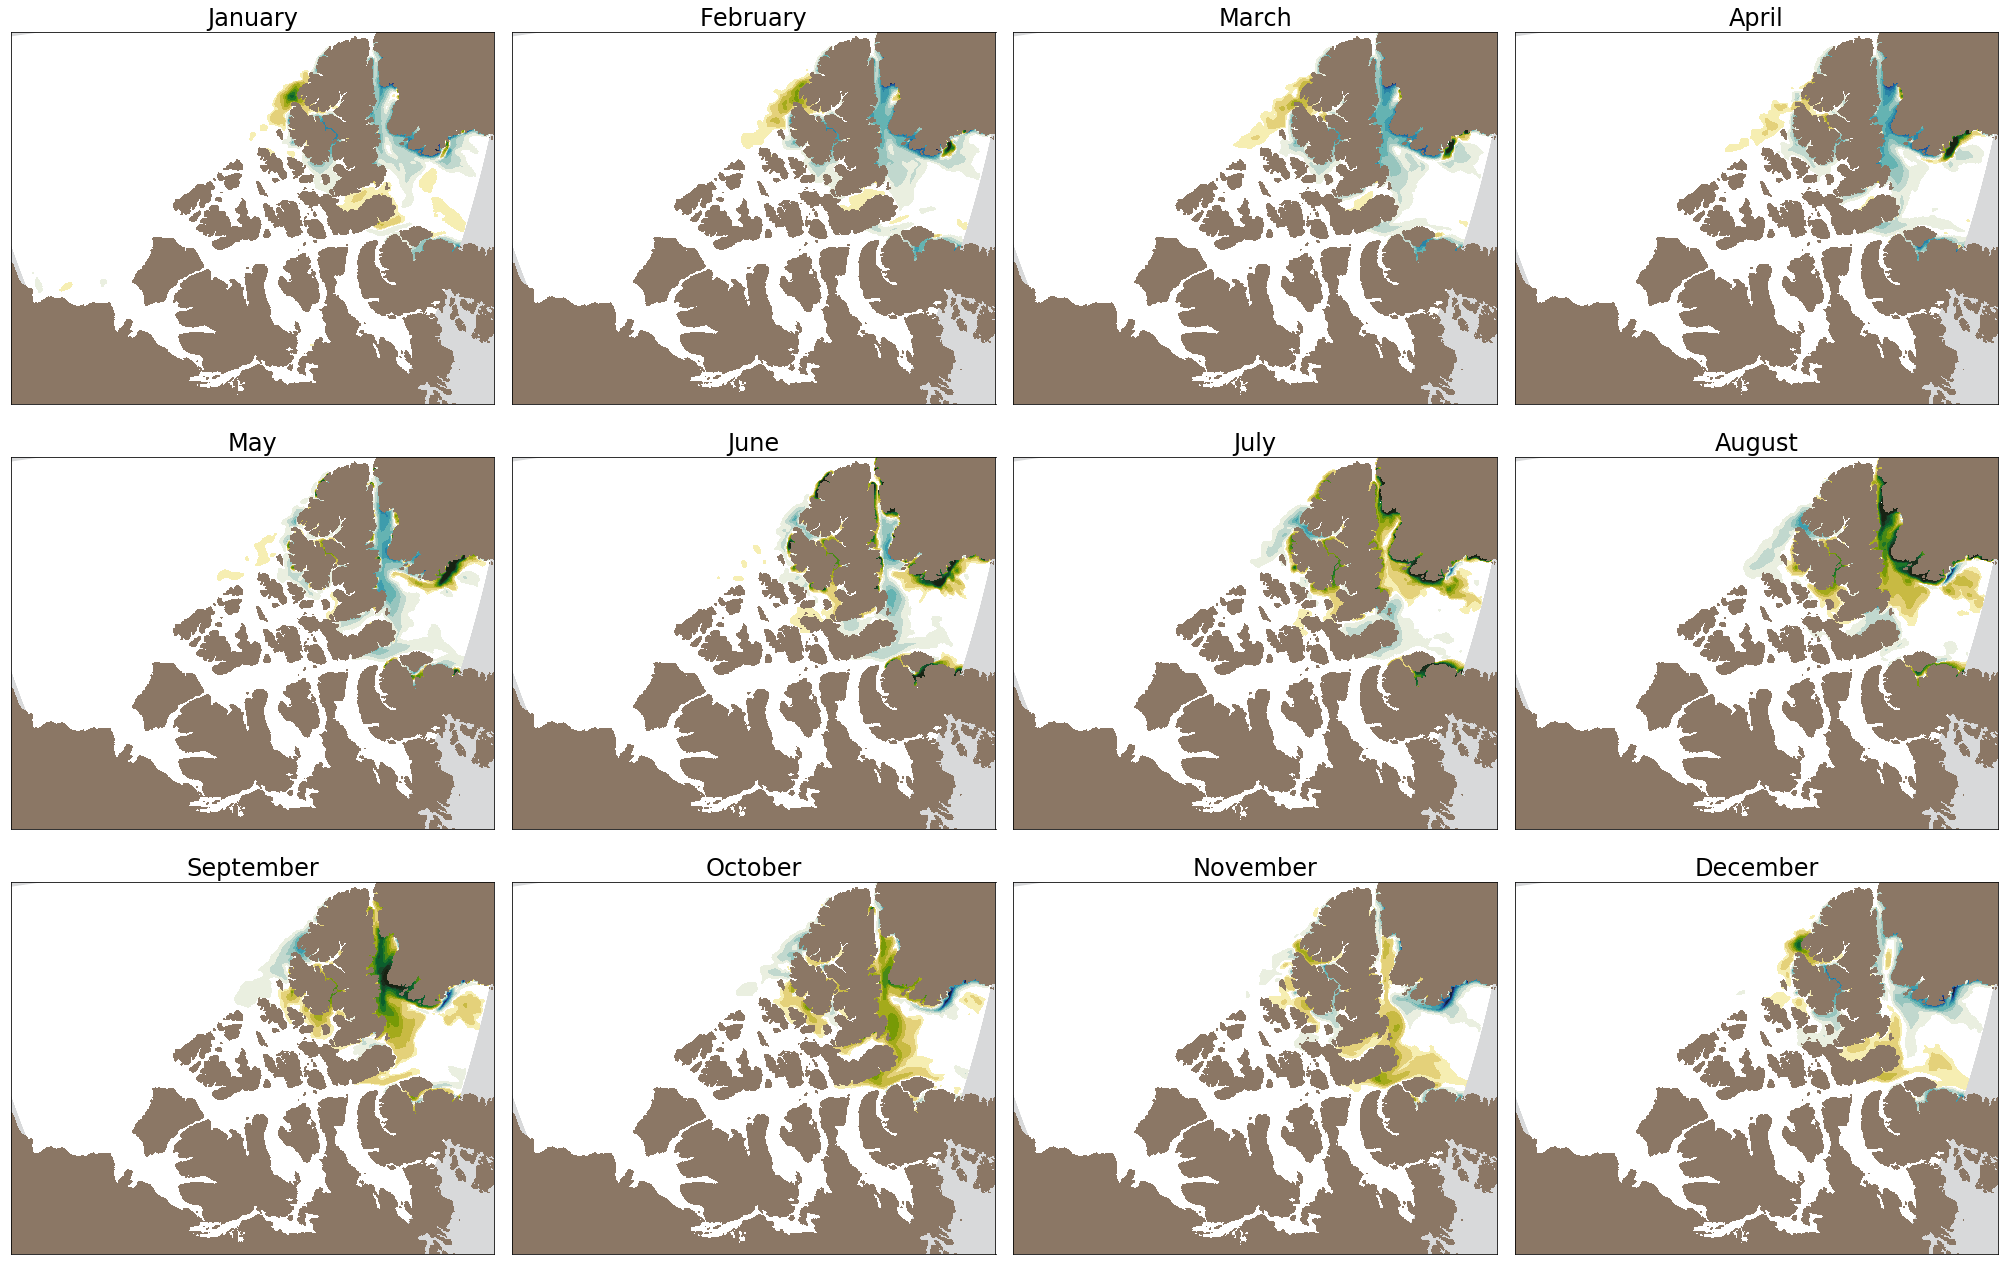

In [73]:
fig, ax = plt.subplots(3,4, figsize=(28,18))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month < 8) & (month > 3):
        ax1 = ax[1,month-4]
    else:
        ax1 = ax[2,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -107, resolution='i', width=2.6e6, height=2.0e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    
    if month==13:#reference_month:
        # Coloured glacours:
        vmin_glac = -12; vmax_glac = 12; step_glac = 2;
        CS1 = proj2.contourf(x_model, y_model, ma_glac[month,:,:]*100, \
                             levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                             vmin=vmin_glac, vmax=vmax_glac, cmap=cmocean.cm.delta, extend='both')
    else:
        vmin_glac = -10; vmax_glac = 10; step_glac = 1;
        CS1 = proj2.contourf(x_model, y_model, diff_glacier[month], \
                             levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                             vmin=vmin_glac, vmax=vmax_glac, cmap=cmocean.cm.delta, extend='both')
        
    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

# fig.suptitle('Difference in glacial contribution relative to January')
    
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

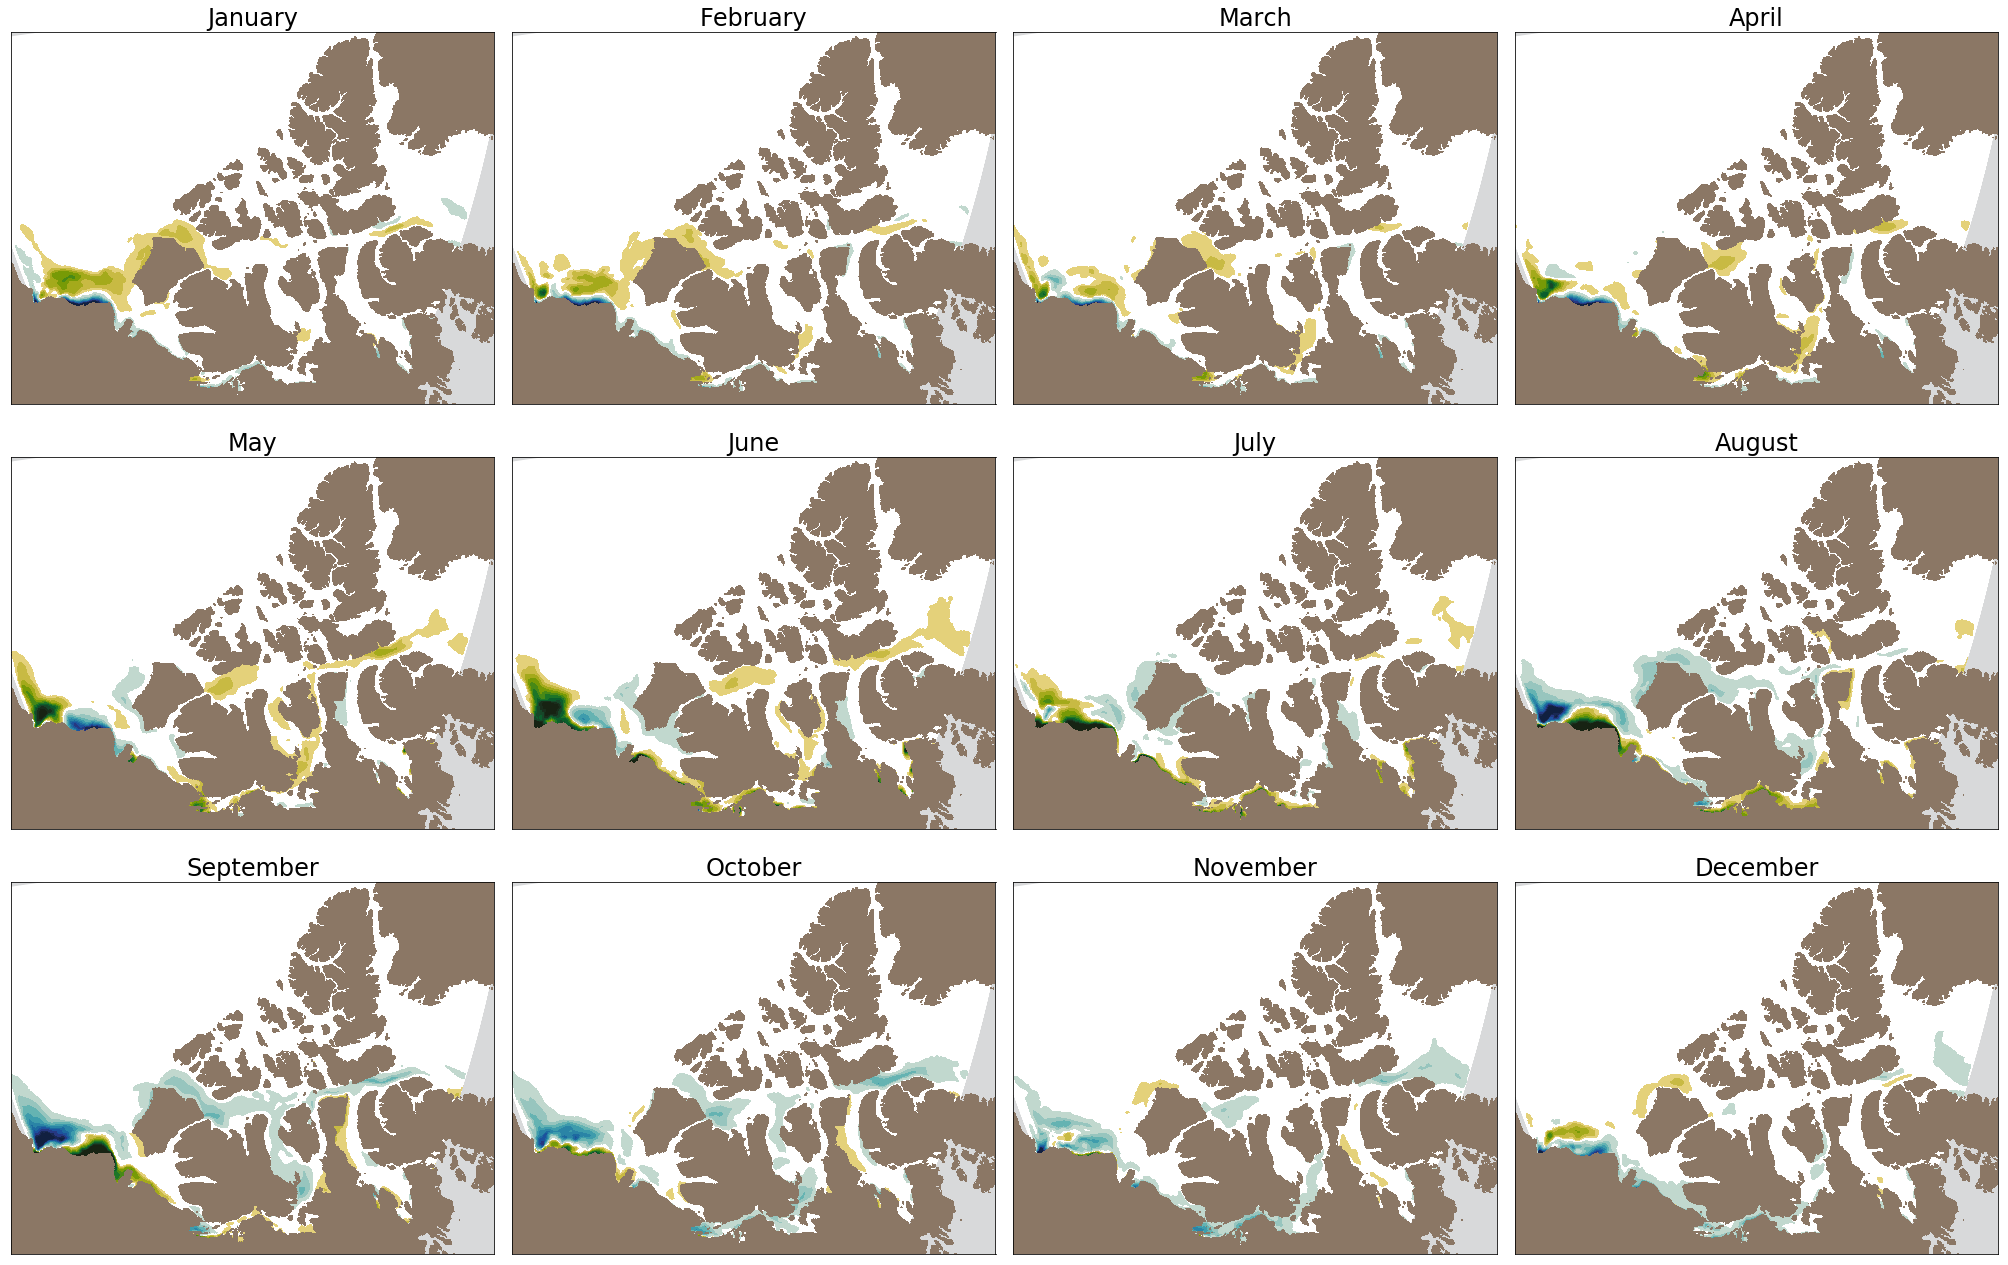

In [74]:
fig, ax = plt.subplots(3,4, figsize=(28,18))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month < 8) & (month > 3):
        ax1 = ax[1,month-4]
    else:
        ax1 = ax[2,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -107, resolution='i', width=2.6e6, height=2.0e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)
    
    if month==13:#reference_month:
        # Coloured contours:
        vmin_cont = -12; vmax_cont = 12; step_cont = 2;
        CS1 = proj2.contourf(x_model, y_model, ma_cont[month,:,:]*100, \
                             levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                             vmin=vmin_cont, vmax=vmax_cont, cmap=cmocean.cm.delta, extend='both')
    else:
        vmin_cont = -5; vmax_cont = 5; step_cont = .5;

        CS1 = proj2.contourf(x_model, y_model, diff_continental[month], \
                             levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                             vmin=vmin_cont, vmax=vmax_cont, cmap=cmocean.cm.delta, extend='both')

    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

# fig.suptitle('Difference in continental contribution relative to January')
    
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)